In [1]:
import torch
import torch.nn as nn
from torchvision import transforms,datasets
import os
import matplotlib.pyplot as plt
import zipfile

In [2]:
import torch
print(torch.__version__)          # Shows PyTorch version and CUDA version if available
print(torch.version.cuda)         # Shows CUDA version PyTorch was compiled with
print(torch.cuda.is_available())  # True if GPU with CUDA is usable


2.5.1+cu121
12.1
True


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("./dataset")

In [4]:
for dir_path,dir_name,file_name in os.walk("dataset"):
    print(f"dir: {dir_path.split('\\')[-1]} -> {len(file_name)}")


dir: dataset -> 1
dir: test -> 0
dir: angry -> 958
dir: disgust -> 111
dir: fear -> 1024
dir: happy -> 1774
dir: neutral -> 1233
dir: sad -> 1247
dir: surprise -> 831
dir: train -> 0
dir: angry -> 3995
dir: disgust -> 436
dir: fear -> 4097
dir: happy -> 7215
dir: neutral -> 4965
dir: sad -> 4830
dir: surprise -> 3171


### data dir

In [6]:
train_dir = "dataset/train"
test_dir = "dataset/test"

angry


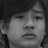

In [7]:
from PIL import Image
import random
import pathlib
img_path = list(pathlib.Path(train_dir).glob("*/*.jpg"))
random_img_path = random.sample(img_path,k=1)[0]
print(random_img_path.parent.stem)
random_img = Image.open(random_img_path)
random_img

In [8]:
# train_img_transformer = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.RandomHorizontalFlip(0.5),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225]),
# ])

train_img_transformer = transforms.Compose([
    transforms.Resize(256),                             # Resize shorter side to 256
    transforms.CenterCrop(224),                         # Crop center 224x224
    transforms.RandomHorizontalFlip(0.5),               # Horizontally flip 50% of images
    transforms.RandomRotation(15),                       # Rotate images upto 15 degrees
    transforms.ColorJitter(brightness=0.2,              # Change brightness, contrast
                           contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Slight translate augmentation
    transforms.ToTensor(),                               # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406],          # Normalize using ImageNet means and stds
                         [0.229, 0.224, 0.225]),
])



test_img_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


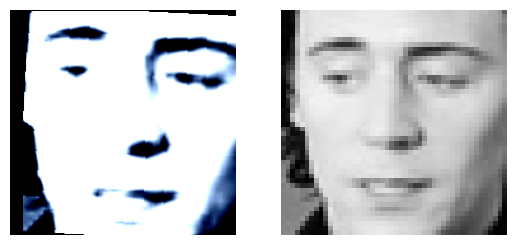

In [9]:
def plt_random_img():
    img_path = list(pathlib.Path(train_dir).glob("*/*.jpg"))
    random_img_path = random.sample(img_path,k=1)[0]
    random_img = Image.open(random_img_path).convert('RGB')
    img_label = random_img_path.parent.stem
    transformed_img = train_img_transformer(random_img)

    fig,ax = plt.subplots(nrows=1, ncols=2)

    ax[0].imshow(transformed_img.permute(1,2,0),cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(random_img)
    ax[1].axis('off')
    plt.show()
plt_random_img()

# image dataset

In [10]:
train_dataset = datasets.ImageFolder(train_dir,transform=train_img_transformer)
test_dataset = datasets.ImageFolder(test_dir,transform=test_img_transformer)

In [12]:
class_names = train_dataset.classes
class_with_idx = train_dataset.class_to_idx
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [15]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=8,pin_memory=True)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=True,num_workers=8,pin_memory=True)

In [16]:
len(train_dataloader),len(test_dataloader)

(898, 225)

### alexNet

In [17]:
# class AlexNet(nn.Module):
#     def __init__(self):
#         super(AlexNet, self).__init__()


In [14]:
def accuracy_func(y_true, y_pred):
    correct = (y_pred == y_true).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy * 100

In [15]:
from torchvision.models import alexnet
from tqdm.auto import tqdm
def training_step(model,traing_dataloader,loss_fn,optimizer,accuracy_fn):
    batch_loss = 0
    batch_accuracy = 0
    model.train()
    for batch,(x,y) in enumerate(traing_dataloader):
        y_logits = model(x.to(device))
        loss = loss_fn(y_logits,y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_prob = torch.softmax(y_logits,dim=1)
        y_pred = torch.argmax(y_prob,dim=1)
        accuracy = accuracy_fn(y.to(device),y_pred)
        batch_accuracy += accuracy
        batch_loss += loss.item()

    batch_accuracy = batch_accuracy / len(traing_dataloader)
    batch_loss = batch_loss / len(traing_dataloader)
    print(f"Batch Train loss: {batch_loss:.2f} -- Batch Accuracy: {batch_accuracy:.2f}")
    return batch_loss,batch_accuracy

D:\Pycharm\emotion detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def testing_step(model,test_dataloader,loss_fn,accuracy_fn):
    batch_test_loss = 0
    batch_test_accuracy = 0
    model.eval()
    with torch.inference_mode():
        for x,y in test_dataloader:
            y_logits = model(x.to(device))
            batch_test_loss += loss_fn(y_logits,y.to(device)).item()

            y_prob = torch.softmax(y_logits,dim=1)
            y_pred = torch.argmax(y_prob,dim=1)
            batch_test_accuracy += accuracy_fn(y.to(device),y_pred)

        batch_test_loss = batch_test_loss / len(test_dataloader)
        batch_test_accuracy = batch_test_accuracy / len(test_dataloader)
        print(f"batch test loss {batch_test_loss:.2f} -- batch test accuracy: {batch_test_accuracy:.2f}")
        return batch_test_loss,batch_test_accuracy

In [17]:
check_point = torch.load('models/alex_model_v6_full_optim.pt',weights_only=False)
alex_model = alexnet(pretrained=False)
alex_model.classifier[6] = nn.Linear(4096, len(class_names))
for param in alex_model.features.parameters():
    param.requires_grad = True

alex_model.load_state_dict(check_point["model_state"])

alex_model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(alex_model.parameters(),lr=1e-5,weight_decay=1e-4)
# optim.load_state_dict(check_point["optimizer_state"])

D:\Pycharm\emotion detection\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Pycharm\emotion detection\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
model_result = {
        "train_loss": [],
        "test_loss": [],
        "train_accuracy": [],
        "test_accuracy": [],
        "epoch": 0
}

In [23]:

EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):

    train_loss,train_acc = training_step(alex_model,train_dataloader,loss_function,optim,accuracy_func)
    test_loss,test_acc = testing_step(alex_model,test_dataloader,loss_function,accuracy_func)

    model_result["test_loss"].append(test_loss)
    model_result["train_loss"].append(train_loss)
    model_result["train_accuracy"].append(train_acc)
    model_result["test_accuracy"].append(test_acc)
    model_result["epoch"] += 1

  0%|          | 0/10 [00:00<?, ?it/s]

Batch Train loss: 1.04 -- Batch Accuracy: 61.93


 10%|█         | 1/10 [01:35<14:16, 95.19s/it]

batch test loss 1.00 -- batch test accuracy: 64.65
Batch Train loss: 0.90 -- Batch Accuracy: 66.43


 20%|██        | 2/10 [02:51<11:11, 83.95s/it]

batch test loss 1.01 -- batch test accuracy: 64.72
Batch Train loss: 0.86 -- Batch Accuracy: 67.89


 30%|███       | 3/10 [04:14<09:46, 83.84s/it]

batch test loss 0.99 -- batch test accuracy: 65.81
Batch Train loss: 0.84 -- Batch Accuracy: 68.69


 40%|████      | 4/10 [05:34<08:13, 82.19s/it]

batch test loss 0.99 -- batch test accuracy: 65.62
Batch Train loss: 0.81 -- Batch Accuracy: 69.65


 50%|█████     | 5/10 [07:04<07:04, 84.98s/it]

batch test loss 1.01 -- batch test accuracy: 65.31
Batch Train loss: 0.79 -- Batch Accuracy: 70.70


 60%|██████    | 6/10 [08:59<06:20, 95.01s/it]

batch test loss 0.99 -- batch test accuracy: 65.90
Batch Train loss: 0.77 -- Batch Accuracy: 71.34


 70%|███████   | 7/10 [10:50<05:01, 100.48s/it]

batch test loss 0.99 -- batch test accuracy: 66.26
Batch Train loss: 0.75 -- Batch Accuracy: 72.08


 80%|████████  | 8/10 [12:27<03:18, 99.20s/it] 

batch test loss 0.99 -- batch test accuracy: 65.81
Batch Train loss: 0.74 -- Batch Accuracy: 72.50


 90%|█████████ | 9/10 [14:24<01:44, 104.89s/it]

batch test loss 1.01 -- batch test accuracy: 65.83
Batch Train loss: 0.72 -- Batch Accuracy: 73.05


100%|██████████| 10/10 [16:15<00:00, 97.58s/it] 

batch test loss 1.01 -- batch test accuracy: 65.74


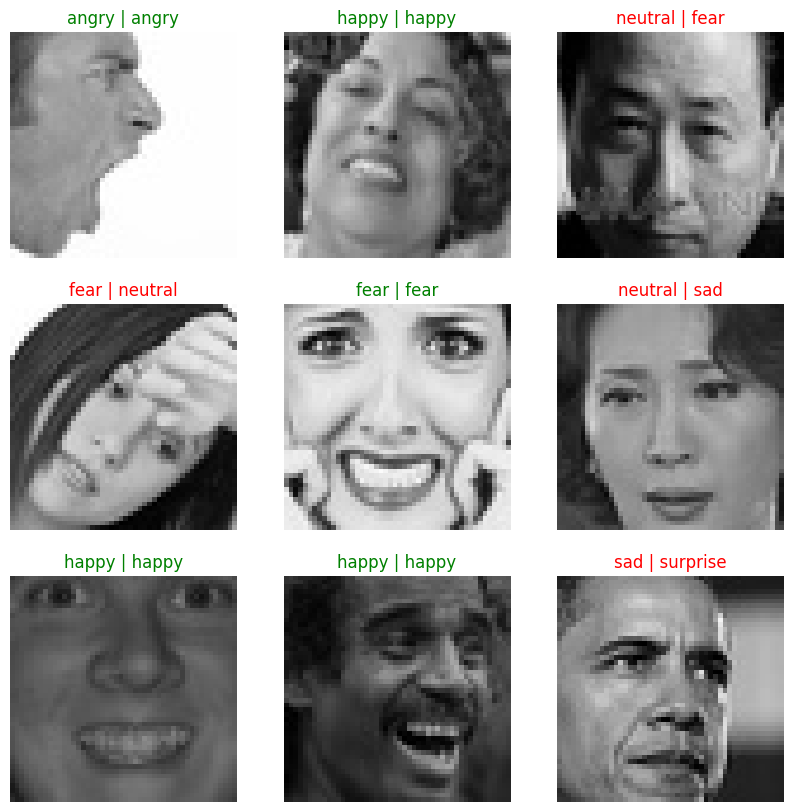

In [24]:
image_path = list(pathlib.Path(test_dir).glob("*/*.jpg"))
random_img_path = random.sample(image_path,9)
img_set = 0

plt.figure(figsize=(10,10))
for image_path in random_img_path:
    img_set +=1
    random_img = Image.open(image_path).convert("RGB")
    transfomed_random_img = test_img_transformer(random_img)
    alex_model.eval()
    with torch.inference_mode():
        y_logits = alex_model(transfomed_random_img.unsqueeze(0).to(device))

        y_prob = torch.softmax(y_logits,dim=1)
        y_pred = torch.argmax(y_prob,dim=1)

    # plt.subplots(nrows=2, ncols=2)
    plt.subplot(3,3,img_set)
    plt.imshow(random_img)

    if class_names[y_pred] == image_path.parent.stem:
        plt.title(f"{class_names[y_pred]} | {image_path.parent.stem}",color="green")
    else:
        plt.title(f"{class_names[y_pred]} | {image_path.parent.stem}",color="red")

    plt.axis('off')
plt.show()


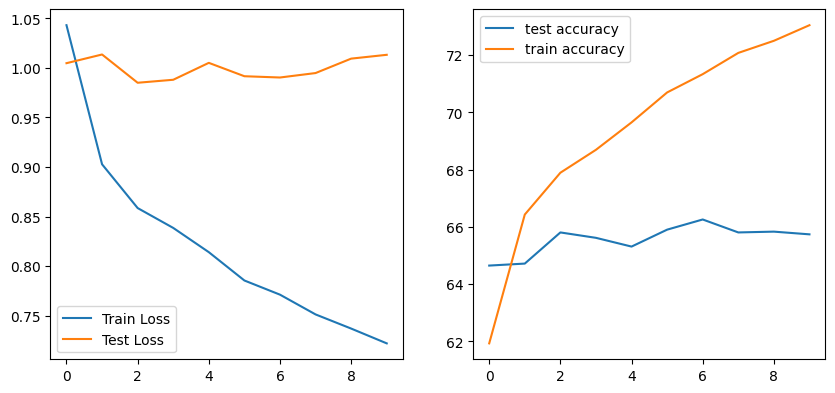

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(range(model_result["epoch"]),model_result["train_loss"],label="Train Loss")
plt.plot(range(model_result["epoch"]),model_result["test_loss"],label="Test Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(model_result["epoch"]),model_result["test_accuracy"],label = "test accuracy")
plt.plot(range(model_result["epoch"]),model_result["train_accuracy"],label = "train accuracy")
plt.legend()
plt.show()

In [ ]:
MODEL_FILE_PATH = "models/alex_model_v7_test_for_college.pt"
torch.save({
    "model_state":alex_model.state_dict(),
    "optimizer_state":optim.state_dict(),
    "epoch":model_result["epoch"]
},MODEL_FILE_PATH)

In [ ]:
import json
with open("models/v7.json",'w') as f:
    json.dump(model_result,f,indent=4)

### prediction

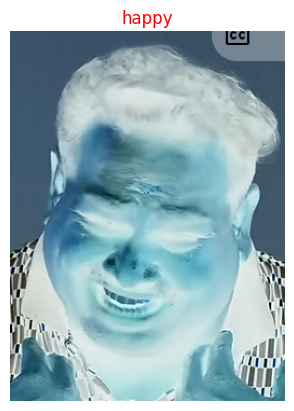

In [18]:
from PIL import ImageOps
PREDICT_PATH = "dataset/predict.png"
predict_img = Image.open(PREDICT_PATH).convert("RGB")
predict_transformed_img = test_img_transformer(predict_img)

alex_model.eval()
with torch.inference_mode():
    y_logits = alex_model(predict_transformed_img.unsqueeze(0).to(device))
    y_prob = torch.softmax(y_logits,dim=1)
    y_pred = torch.argmax(y_prob,dim=1)

predicted_label = class_names[y_pred]
plt.imshow(ImageOps.invert(predict_img),cmap="gray")
plt.axis('off')
plt.title(f"{class_names[y_pred]}",color="red")
plt.show()

In [40]:
predict_transformed_img.shape

torch.Size([3, 224, 224])